# Question 02
- Using the class example of transfer learning from the class, pick a different context (- not dogs) and develop an image classification problem with a limited amount of training data (20-30 images).
- Note: use a context that is listed in the VGG16 ResNet class labels. 

In [4]:
# Tensorflow 2
import tensorflow as tf
from tensorflow import keras as t
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.utils import to_categorical

# Specific to VGG16 and Transfer learning
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
from PIL import Image
import glob

## VGG16

In [5]:
# load the VGG16 network *pre-trained* on the ImageNet dataset
model = VGG16(weights="imagenet")
model.summary()

553467096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [6]:
for filename in glob.glob('dog/*.jpg'):
    im=Image.open(filename)
    print(im)
    plt.imshow(im)
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Pre process function


In [7]:
def load_and_process_image(image_path):    
    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    return image

## Create prediction

In [9]:
def readable_prediction(image_path):
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))

## Make predictions

In [16]:
for filename in glob.glob('dog/*.jpg'):
    im=Image.open(filename)
    plt.imshow(im)
    plt.show()
    readable_prediction(filename)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
for filename in glob.glob('elephant/*.jpg'):
    im=Image.open(filename)
    plt.imshow(im)
    plt.show()
    readable_prediction(filename)

Output hidden; open in https://colab.research.google.com to view.

## Use Raw value for dog

In [12]:
def dog_door(image_path):
    image = load_and_process_image(image_path)
    preds = model.predict(image)
    # for the VGG16 model, from the softmax classes, 151 to 268 are dogs
    if 151 <= np.argmax(preds) <= 268:
        print("Dog detected: Open Door")
    else:
        print("Not Dog: Close Door")

In [14]:
for filename in glob.glob('dog/*.jpg'):
    im=Image.open(filename)
    plt.imshow(im)
    plt.show()
    dog_door(filename)

Output hidden; open in https://colab.research.google.com to view.

In [15]:
for filename in glob.glob('elephant/*.jpg'):
    im=Image.open(filename)
    plt.imshow(im)
    plt.show()
    dog_door(filename)

Output hidden; open in https://colab.research.google.com to view.

## Transfer Learning
Will be more specific with the dog type which is Borzoi

In [18]:
base_model = tf.keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

base_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [19]:
base_model.trainable = False

In [20]:
inputs = tf.keras.Input(shape=(224, 224, 3))

# Separately from setting trainable on the model, we set training to False 
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1000, activation="relu")(x)


# A Dense classifier with a single unit (binary classification)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1000)              513000    
                                                                 
 dense_1 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 15,228,689
Trainable params: 514,001
Non-trainable params: 14,714,688
___________________________________________

### Compiling the model

In [21]:
model.compile(loss="binary_crossentropy", metrics=["acc"])

In [24]:
X =[]
Y =[]
for filename in glob.glob('trainingData/borzoi/*.jpg'):
    im=Image.open(filename)
    im = im.resize((224,224),Image.ANTIALIAS)
    arr = np.array(im)
    X.append(arr)
    Y.append(0)  # Arya

for filename in glob.glob('trainingData/notBorzoi/*.jpg'):
    im=Image.open(filename)
    im = im.resize((224,224),Image.ANTIALIAS)
    arr = np.array(im)
    X.append(arr)
    Y.append(1)  # Neighbours dog


    
# Convert to NP array
X = np.array(X)


X = X.reshape(X.shape[0],224, 224,3)

# Normalize the data
X = X /255

# Encode outputs
Y = np.array(Y)

# randomize the data set - numpy arrays
randomize = np.arange(len(X))
np.random.shuffle(randomize)
X = X[randomize]
Y = Y[randomize]

Epoch 1/20
43/43 [==============================] - 37s 865ms/step - loss: 0.8980 - acc: 0.5814 - val_loss: 0.6158 - val_acc: 0.5814
Epoch 2/20
43/43 [==============================] - 40s 944ms/step - loss: 0.6048 - acc: 0.6512 - val_loss: 0.7373 - val_acc: 0.4651
Epoch 3/20
43/43 [==============================] - 39s 925ms/step - loss: 0.5292 - acc: 0.6977 - val_loss: 0.3272 - val_acc: 0.8140
Epoch 4/20
43/43 [==============================] - 39s 915ms/step - loss: 0.4145 - acc: 0.8372 - val_loss: 0.2460 - val_acc: 0.9070
Epoch 5/20
43/43 [==============================] - 37s 866ms/step - loss: 0.2818 - acc: 0.8837 - val_loss: 0.2541 - val_acc: 0.9070
Epoch 6/20
43/43 [==============================] - 33s 768ms/step - loss: 0.2125 - acc: 0.9070 - val_loss: 0.1501 - val_acc: 0.9535
Epoch 7/20
43/43 [==============================] - 37s 865ms/step - loss: 0.2134 - acc: 0.9070 - val_loss: 0.1183 - val_acc: 0.9767
Epoch 8/20
43/43 [==============================] - 32s 755ms/step - 

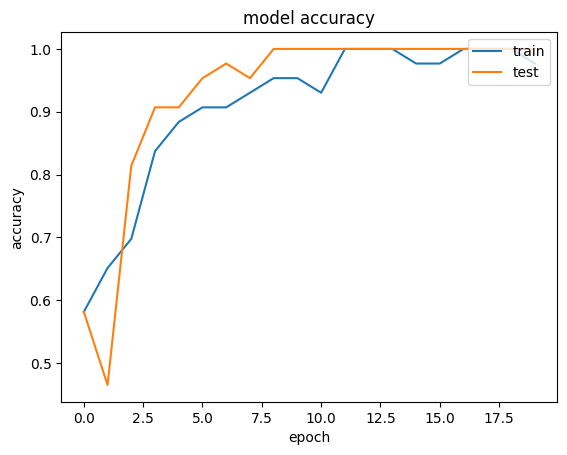

In [25]:
history = model.fit(X, Y, validation_data=(X,Y), epochs=20, batch_size=1, verbose=1)

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Final Prediction

In [30]:
def tf_prediction(image_path):
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    prediction = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', prediction)
    return prediction

In [31]:
for filename in glob.glob('trainingData/borzoi/*.jpg'):
    im=Image.open(filename)
    plt.imshow(im)
    plt.show()
    tf_prediction(filename)

Output hidden; open in https://colab.research.google.com to view.

In [32]:
for filename in glob.glob('trainingData/notBorzoi/*.jpg'):
    im=Image.open(filename)
    plt.imshow(im)
    plt.show()
    tf_prediction(filename)

Output hidden; open in https://colab.research.google.com to view.

## Start predictions

In [33]:
for filename in glob.glob('trainingData/borzoi/*.jpg'):
    im=Image.open(filename)
    plt.imshow(im)
    plt.show()
    if tf_prediction(filename)[0][0] < 0.5:
        print("It is Borzoi - open the door")
    else:
        print("It not Borzoi - do not open the door")

for filename in glob.glob('trainingData/notBorzoi/*.jpg'):
    im=Image.open(filename)
    plt.imshow(im)
    plt.show()
    if tf_prediction(filename)[0][0] < 0.5:
        print("It is Borzoi - open the door")
    else:
        print("It not Borzoi - do not open the door")

Output hidden; open in https://colab.research.google.com to view.